In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Print column names within the measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).all()
recent_date[0][0]

'2017-08-23'

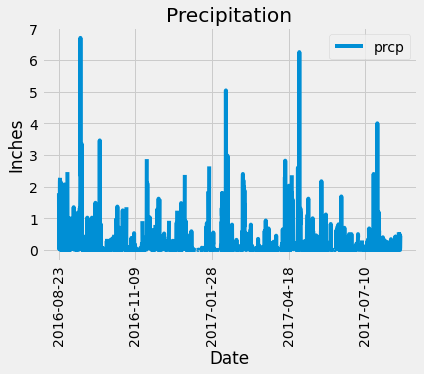

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
string_date = recent_date[0][0].split('-')
year = int(string_date[0])
month = int(string_date[1])
day = int(string_date[2])
first_date =dt.date(year,month,day)
first_date
# Calculate the date one year from the last date in data set.
last_date = first_date - dt.timedelta(days=365)
last_date
# Perform a query to retrieve the data and precipitation scores
twelve_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
pcip_data = pd.DataFrame(twelve_months, columns=['date','prcp'])
pcip_date_data = pcip_data.set_index('date')
# Sort the dataframe by date
pcip_date_data = pcip_date_data.sort_index()
pcip_date_data.head()
# Use Pandas Plotting with Matplotlib to plot the data

pcip_date_data.plot(rot=90)
plt.title('Precipitation')
plt.xlabel("Date")
plt.ylabel('Inches')
plt.legend(loc='best')

In [12]:
import scipy.stats as sts

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_numpy = np.mean(pcip_date_data)
print(mean_numpy)
median_numpy = np.median(pcip_date_data['prcp'])
print(median_numpy)
mode_scipy = sts.mode(pcip_date_data['prcp'])
print(mode_scipy)
print(sts.normaltest(pcip_date_data.sample(100)))
print(sts.zscore(pcip_date_data))
pcip_date_data['prcp'].describe()

prcp    0.177279
dtype: float64
nan
ModeResult(mode=array([0.]), count=array([874]))
NormaltestResult(statistic=array([nan]), pvalue=array([nan]))
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number stations in the dataset
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])
    


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()